### Import stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import xesmf

In [3]:
import sys  
sys.path.insert(0, '/home/jupyter/InternalVariability/AdaptationAnalysis')

In [4]:
from app.main.src.climate_projection import ClimateProjection
from app.main.src.year_of_departure import *
from app.main.src.datasets import *
from app.main.src.post_processing import BiasCorrection, NoPostProcessing

### CMIP6 analysis for a single location

In [5]:
# set lat/lon
lat = 40
lon = -92

In [6]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],    #TO-DO: figure out what the variables mean
    scenario='ssp585',
    #n_models=5,
    projection_name='CMIP6_daily_local',
    gcs_bucket='climateai_data_repository',      #TO-DO: have this part explained again 
    gcs_path='tmp/analog_test',
    overwrite=False,
    #daily=False
)

In [7]:
# load the data
#cross validate should always be false
cp.load(cross_validate=False,check_exist=True)

some of the datasets that come out are raw_hist_monthly, reanalysis_monthly, pp_hist_monthly, pp_future-monthly

In [8]:
cp.raw_hist_daily

<xarray.Dataset>
Dimensions:  (model: 21, time: 13149)
Coordinates:
    lat      int64 40
    lon      int64 -92
  * model    (model) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NESM3' 'NorESM2-MM'
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2014-12-31
Data variables:
    t2m      (model, time) float32 -3.075 0.2533 -11.42 -2.783 ... nan nan nan
    t2m_max  (model, time) float32 1.544 1.562 -5.272 0.591 ... nan nan nan nan
    t2m_min  (model, time) float32 -6.216 -4.775 -14.84 -8.458 ... nan nan nan
    tp       (model, time) float32 0.1999 0.1944 0.02897 ... 0.272 0.6065 0.941
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-11-09T02:13:27Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

## Reproduce HS09
Here we will reproduce the model uncertainty and internal varaibility estimates using methodology from HS09 (i.e. fitting the data with a 4th order polynomial) 

### Prepare the data 

In [18]:
# inputs : raw or postprocessed 
input1 = cp.pp_hist_daily
input2 = cp.pp_future_daily

# input1 = cp.raw_hist_daily
# input2 = cp.raw_future_daily

In [19]:
# concat the post-processed historical and future datasets 
# resample yearly (AS = yearly resample at the beginning of the calendar year)
# drop models that do not have the t2m variable 
data = xr.concat(
    [input1, input2], dim='time'
).resample(time='AS').mean().t2m.dropna('model')

In [20]:
data

<xarray.DataArray 't2m' (time: 122, model: 13)>
array([[11.0410356 , 11.48028425, 10.71792158, ..., 10.74532675,
        11.25963201, 11.84419072],
       [11.81740653, 11.61314847, 12.10934034, ..., 12.35779082,
        10.68711489, 11.80532424],
       [11.80998165, 12.8023016 , 11.76626412, ..., 11.61352615,
        11.31531145, 12.11804183],
       ...,
       [18.22119987, 20.81010411, 16.74206352, ..., 18.53086881,
        17.07890436, 17.2604138 ],
       [18.86624499, 20.47919872, 17.32783032, ..., 17.45386612,
        17.19957253, 17.32912429],
       [19.19923388, 19.77035569, 17.85249209, ..., 18.06122431,
        15.99108365, 16.94150572]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2100-01-01
    lat      int64 40
    lon      int64 -92
  * model    (model) <U16 'AWI-CM-1-1-MR' 'EC-Earth3-Veg-LR' ... 'NESM3'

In [12]:
# take a decadal rolling average and drop times
data = data.rolling(time=10, center=True).mean().dropna('time')

### Do the 4th order polynomial fit 

In [13]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [16]:
len(data.time)

113

In [15]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [16]:
Z.shape   # why is this the shape of Z, is it because of the polynomial order?


(5, 13)

In [17]:
# make a copy of the data to do the fit using the coefs from Z 
fit = data.copy()

In [18]:
# is this a trick to avoid appending?? why isnt the m used in the for loop?
# what exactly are we doing here? Are we just constructing the fits for each of the models?
for i, m in enumerate(fit.model):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

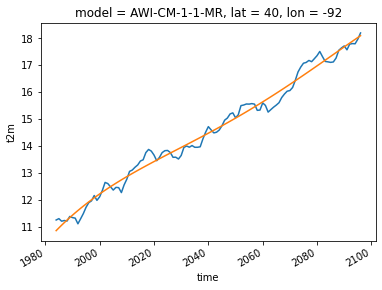

In [19]:
#plot a model and model fit 
data.isel(model=0).plot()
fit.isel(model=0).plot()

Text(0.5, 1.0, '4th Order Poly Fit of CMIP6 (postprocessed, daily) \n Temperature [Deg C] Projections for (lat,lon)=(40,-92)')

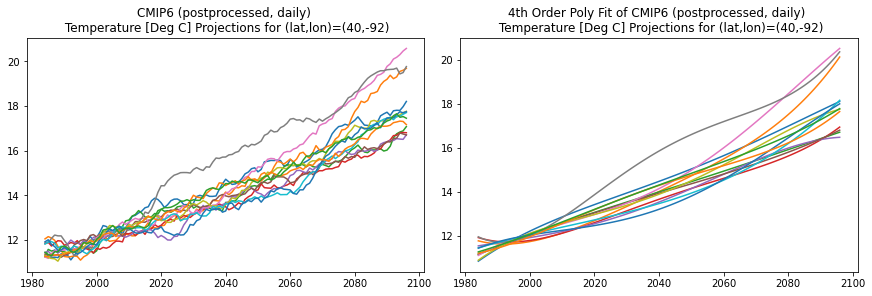

In [21]:
fig,ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data.model)):
    ax[0].plot(data.time.dt.year,data.isel(model=i))
    ax[1].plot(fit.time.dt.year,fit.isel(model=i))
    
ax[0].set_title('CMIP6 (postprocessed, daily) \n Temperature [Deg C] Projections for (lat,lon)=(40,-92)')
ax[1].set_title('4th Order Poly Fit of CMIP6 (postprocessed, daily) \n Temperature [Deg C] Projections for (lat,lon)=(40,-92)')

#### calculate residual 

In [22]:
residual = data - fit 

In [23]:
internal = residual.var('time').mean('model')

In [24]:
model = fit.var('model')

Text(0.5, 1.0, 'CMIP6 Internal Variability for (lat,lon)=(-92,40)')

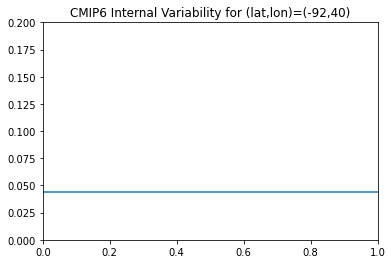

In [25]:
# model.plot()
plt.axhline(internal)
plt.ylim(0,0.2)
plt.title('CMIP6 Internal Variability for (lat,lon)=(-92,40)')

In [26]:
internal

<xarray.DataArray 't2m' ()>
array(0.04427506)
Coordinates:
    lat      int64 40
    lon      int64 -92

In [27]:
total = internal + model 

In [28]:
internal_frac = (internal/total)*100
model_frac = (model/total)*100

Text(0.5, 1.0, 'CMIP6 (post-processed, daily) \n Fractional contribution to total uncertainty (%)')

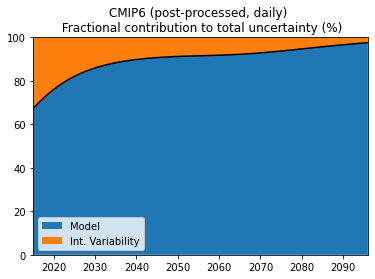

In [30]:
x = model_frac.time
y = model_frac
plt.fill_between(x,y,label='Model')
plt.plot(model_frac.time,model_frac,color='k')
plt.fill_between(x,y,100,label='Int. Variability')
plt.xlim(x[31],x[-1])
plt.ylim(0,100)
plt.legend(loc=3)
plt.title('CMIP6 (post-processed, daily) \n Fractional contribution to total uncertainty (%)')

#### Look at global

In [5]:
lat = slice(None, None)
lon = slice(None, None)

In [6]:
lat

slice(None, None, None)

In [7]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],   
    scenario='ssp585',
#     n_models=5,
    projection_name='cmip6_daily_global',
    gcs_bucket='climateai_data_repository',       
    gcs_path='tmp/analog_test',
    overwrite=False,
    #daily=False
)

In [ ]:
cp.load(cross_validate=False,check_exist=True,
        pp_method={'monthly' : {'t2m':BiasCorrection,
                                't2m_max':BiasCorrection,
                                't2m_min':BiasCorrection,
                                'tp':NoPostProcessing},
                  'daily' : {'t2m':BiasCorrection,
                                't2m_max':BiasCorrection,
                                't2m_min':BiasCorrection,
                                'tp':NoPostProcessing}
                  },
       interp_dx=2.5)

ERROR! Session/line number was not unique in database. History logging moved to new session 40
[Errno KeyError] '.zmetadata': 'gcs://climateai_data_repository/tmp/analog_test/cmip6_daily_global/reanalysis_daily.zarr'
Not all files found. Compute new.
Computing cmip6_daily_global


/opt/conda/envs/climateai/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/climateai/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/conda/envs/cl

In [180]:
# inputs : raw or postprocessed 
# input1 = cp.pp_hist_monthly
# input2 = cp.pp_future_monthly

input1 = cp.raw_hist_monthly
input2 = cp.raw_future_monthly

In [181]:
data = xr.concat(
    [input1, input2], dim='time'
).resample(time='AS').mean().t2m.dropna('model')


In [182]:
# take a decadal rolling average and drop times
data = data.rolling(time=10, center=True).mean().dropna('time')

In [183]:
# global average 
data = data.mean(dim=('lon','lat'))

In [184]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [185]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [186]:
fit = data.copy()

In [187]:
for i, m in enumerate(fit.model):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

Text(0.5, 1.0, '4th Order Poly Fit of CMIP6 (post-processed, monthly) \n Global Temperature [Deg C] Projections')

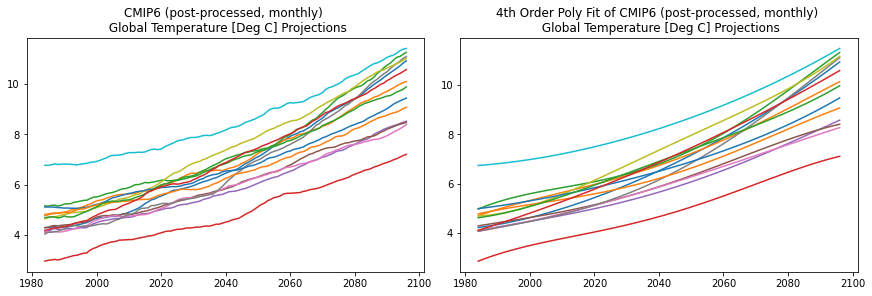

In [188]:
fig,ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data.model)):
    ax[0].plot(data.time.dt.year,data.isel(model=i))
    ax[1].plot(fit.time.dt.year,fit.isel(model=i))
    
ax[0].set_title('CMIP6 (post-processed, monthly) \n Global Temperature [Deg C] Projections')
ax[1].set_title('4th Order Poly Fit of CMIP6 (post-processed, monthly) \n Global Temperature [Deg C] Projections')

In [189]:
residual = data - fit 

In [190]:
internal = residual.var('time').mean('model')

In [191]:
model = fit.var('model')

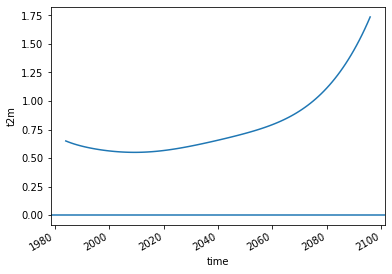

In [192]:
model.plot()
plt.axhline(internal)

In [193]:
total = internal + model 
internal_frac = (internal/total)*100
model_frac = (model/total)*100

Text(0.5, 1.0, 'CMIP6 (post-processed, monthly) \n Fractional contribution to total uncertainty (%)')

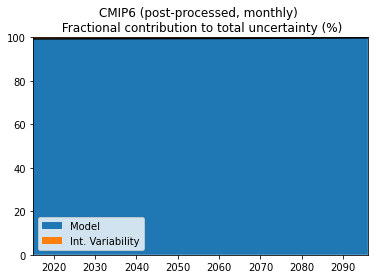

In [194]:
x = model_frac.time
y = model_frac
plt.fill_between(x,y,label='Model')
plt.plot(model_frac.time,model_frac,color='k')
plt.fill_between(x,y,100,label='Int. Variability')
plt.xlim(x[31],x[-1])
plt.ylim(0,100)
plt.legend(loc=3)
plt.title('CMIP6 (post-processed, monthly) \n Fractional contribution to total uncertainty (%)')

(0.0, 0.02)

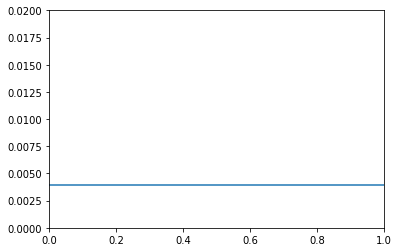

In [195]:
plt.axhline(internal)
plt.ylim(0,0.02)